# Hands-On Neural Networks 
***

In this notebook we'll implement a rudimentary Stochastic Gradient Descent algorithm with Back Propagation to learn the weights in a simple feed-forward neural network.  

**Important Note**: We're basically going to implement 25% of your next homework assignment. I will post the solutions after today's class. Hope that will help with your homework.

**Semi-Important Note**: There are some helper functions at the bottom of this notebook.  Scroll down and evaluate those before proceeding. 

A skeleton of our network class is given below.  We'll update it's functionality piece by piece as we work through the notebook. 

In [34]:
for i in range(10, 0, -1):
    print(i)

10
9
8
7
6
5
4
3
2
1


In [77]:
np.random.seed(4622)
class Network:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n, 1) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m, n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros((n, 1)) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros((n, 1)) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros((n, 1)) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros((n, 1)) for n in self.sizes]
        
    def g(self, z):
        """
        sigmoid activation function 
        
        :param z: vector of activities to apply activation to 
        """
        return 1.0 / (1.0 + np.exp(-z))
    
    def g_prime(self, z):
        """
        derivative of sigmoid activation function 
        
        :param z: vector of activities to apply derivative of activation to 
        """
        return self.g(z) * (1.0 - self.g(z))
    
    def grad_loss(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = (a-y)^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return (a - y)
    
    def forward_prop(self, x):
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        # Initialize activation on initial layer to x 
        # TODO
        self.a[0] = x

        # Loop over layers and compute activities and activations 
        # TODO
        for l in range(self.L - 1):
            self.z[l + 1] = np.dot(self.W[l], self.a[l]) + self.b[l]
            self.a[l + 1] = self.g(self.z[l + 1])
            
        
            
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        # forward prop training example to fill in activities and activations 
        # TODO
        self.forward_prop(x)
        
        # compute deltas on output layer 
        self.delta[self.L - 1] = self.grad_loss(self.a[self.L - 1], y) * self.g_prime(self.z[self.L - 1])
        
        # loop backward through layers, backprop deltas, compute dWs and dbs
        for l in range(self.L - 2, -1, -1):
            self.dW[l] = np.dot(self.delta[l + 1], self.a[l].T)
            self.db[l] = self.delta[l + 1]
            self.delta[l] = np.dot(self.W[l].T, self.delta[l + 1]) * self.g_prime(self.z[l]) 
            

            
    def train(self, X_train, y_train, X_valid=None, y_valid=None,
              eta=0.25, num_epochs=10, isPrint=True, isVis=False):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded labels 
        """
        
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        # loop over training epochs 
        for ep in range(1, num_epochs+1):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)
            
            # loop over training examples 
            for ind in shuffled_inds:
                               
                # back prop to get derivatives 
                self.back_prop(X_train[ind], y_train[ind])
                
                # update weights and biases
                for l in range(self.L - 1):
                    self.W[l] -= (eta * self.dW[l])
                    self.b[l] -= (eta * self.db[l])
                
            # print mean loss every 10 epochs if requested 
            if isPrint and (ep % 10) == 0:
                print("epoch {:3d}/{:3d}: ".format(ep, num_epochs), end="")
                print("  train loss: {:8.3f}".format(self.compute_loss(X_train, y_train)), end="")
                if X_valid is not None:
                    print("  validation loss: {:8.3f}".format(self.compute_loss(X_valid, y_valid)))
                else:
                    print("")
                    
            if isVis and (ep % 20) == 0:
                self.pretty_pictures(X_train, y_train, decision_boundary=True, epoch=ep)
                    
    def compute_loss(self, X, y):
        """
        compute average loss for given data set 
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        """
        loss = 0
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[np.newaxis, :]
        for x, t in zip(X, y):
            self.forward_prop(x)
            if len(t.shape) == 1:
                t = t.reshape(-1, 1)
            loss += 0.5 * np.sum((self.a[-1] - t) ** 2)
        return loss / X.shape[0]
    
    
    def gradient_check(self, x, y, h=1e-5):
        """
        check whether the gradient is correct for X, y
        
        Assuming that back_prop has finished.
        """
        for ll in range(self.L - 1):
            oldW = self.W[ll].copy()
            oldb = self.b[ll].copy()
            for i in range(self.W[ll].shape[0]):
                for j in range(self.W[ll].shape[1]):
                    self.W[ll][i, j] = oldW[i, j] + h
                    lxph = self.compute_loss(x, y)
                    self.W[ll][i, j] = oldW[i, j] - h
                    lxmh = self.compute_loss(x, y)
                    grad = (lxph - lxmh) / (2 * h)
                    assert abs(self.dW[ll][i, j] - grad) < 1e-5
                    self.W[ll][i, j] = oldW[i, j]
            for i in range(self.b[ll].shape[0]):
                j = 0
                self.b[ll][i, j] = oldb[i, j] + h
                lxph = self.compute_loss(x, y)
                self.b[ll][i, j] = oldb[i, j] - h
                lxmh = self.compute_loss(x, y)
                grad = (lxph - lxmh) / (2 * h)
                assert abs(self.db[ll][i, j] - grad) < 1e-5
                self.b[ll][i, j] = oldb[i, j]
        
        
            
    def pretty_pictures(self, X, y, decision_boundary=False, epoch=None):
        """
        Function to plot data and neural net decision boundary
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        :param decision_boundary: whether or not to plot decision 
        :param epoch: epoch number for printing 
        """
        
        mycolors = {"blue": "steelblue", "red": "#a76c6e"}
        colorlist = [c for (n,c) in mycolors.items()]
        colors = [colorlist[np.argmax(yk)] for yk in y]

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
        
        if decision_boundary:
            xx, yy = np.meshgrid(np.linspace(-1.25,1.25,300), np.linspace(-1.25,1.25,300))
            grid = np.column_stack((xx.ravel(), yy.ravel()))
            grid_pred = np.zeros_like(grid[:,0])
            for ii in range(len(grid_pred)):
                self.forward_prop(grid[ii,:])
                grid_pred[ii] = np.argmax(self.a[-1])
            grid_pred = grid_pred.reshape(xx.shape)
            cmap = ListedColormap([
                colorConverter.to_rgba('steelblue', alpha=0.30),
                colorConverter.to_rgba('#a76c63', alpha=0.30)])
            plt.contourf(xx, yy, grid_pred, cmap=cmap)
            if epoch is not None: plt.text(-1.23,1.15, "epoch = {:d}".format(epoch), fontsize=16)

        plt.scatter(X[:,0], X[:,1], color=colors, s=100, alpha=0.9)
        plt.axis('off')

### Part 1: Two-Dimensional Data 
***

**Part A**: We'll be using our network to do binary classification of two-dimensional feature vectors.  Scroll down to the **Helper Functions** and examine the function ``generate_data``. Then mess around with the following cell to look at the various data sets available.  

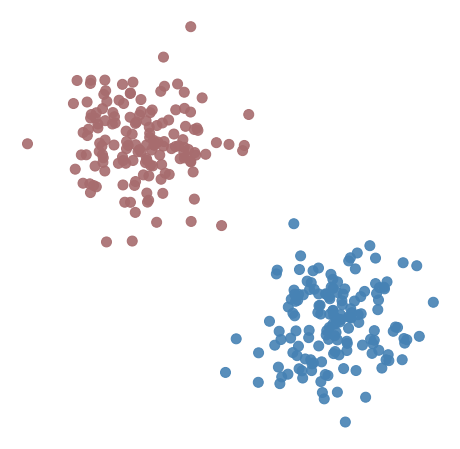

In [5]:
nn = Network([2,3,2])
X_train, y_train = generate_data(300, "blobs")
nn.pretty_pictures(X_train, y_train, decision_boundary=False)

**Part B**: Look at a few of the training examples, in particular pay attention to the way that the labels in ``y_train`` are encoded.  Why might we want to encode labels in this way? 

Note that for illustration purposes, we are using regression-style loss functions here.

In [6]:
y_train[:5]

array([[1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0]])

### Part 2: Implementing Forward Propagation 
***

**Part A**: Go up to the ``__init__`` function in the ``Network Class``.  How are we initializing a network?  What data structures are we using to store things like weights, biases, deltas, etc? 

**Part B**: Complete the ``forward_prop`` function to implement forward propagation.  Your function should take in a single training example ``x`` and propagate it forward in the network, setting the activations and activities on the hidden and output layers.  Remember that the pseudocode that we wrote for forward-prop looked as follows: 

1. $\quad$Initialize ${\bf a}^1 = {\bf x}$
2. $\quad$For $\ell = 1, \ldots, L-1$: 
3. $\quad\quad\quad{\bf z}^{\ell+1} = W^\ell {\bf a}^\ell + {\bf b}^\ell$
3. $\quad\quad\quad{\bf a}^{\ell+1} = g({\bf z}^{\ell+1})$

**Note**: You'll have to adjust this method to deal with Python's zero-based indexing. 

When you think you're done, we can instantiate a ``Network`` with with $2$ neurons in the input layer, $3$ neurons in the sole hidden layer, and $2$ neurons in the output layer, and then forward prop one of the training examples. 

Check that your indexing was correct by making sure that all of the activations are now non-zero (remember, we initialized them to vectors of zeros). 

What other things could we check? 

In [16]:
nn = Network([2,3,2])
nn.forward_prop(X_train[0])

In [17]:
nn.a

[array([[ 0.33342913],
        [-0.81929762]]),
 array([[0.46165163],
        [0.61634345],
        [0.59097472]]),
 array([[0.66785836],
        [0.6728306 ]])]

In [18]:
nn.z

[array([[0.],
        [0.]]),
 array([[-0.1536953 ],
        [ 0.47405659],
        [ 0.36799627]]),
 array([[0.6985146 ],
        [0.72101552]])]

In [19]:
X_train[0]

array([ 0.33342913, -0.81929762])

### Part 3: Implementing Back Propagation 
***

**Part A**: OK, now it's time to implement back propagation.  Complete the function ``back_prop`` in the ``Network`` class to use a single training example to compute the derivatives of the loss function with respect to the weights and the biases.  Remember, the pseudocode for back-prop was as follows: 

1. $\quad$Forward propagate the training example ${\bf x}$, ${\bf y}$
2. $\quad$Compute the $\delta^L = \dfrac{\partial \mathscr{L}}{\partial {\bf a}^L} \odot g'({\bf z}^L)$
3. $\quad$For $\ell = L-1, \ldots, 1$: 
4. $\quad\quad\quad \dfrac{\partial \mathscr{L}}{\partial W^\ell} = \delta^{\ell+1} ({\bf a}^\ell)^T$
5. $\quad\quad\quad \dfrac{\partial \mathscr{L}}{\partial {\bf b}^\ell} = \delta^{\ell+1}$
6. $\quad\quad\quad\delta^{\ell} = (W^\ell)^T\delta^{\ell+1} \odot g'({\bf z}^\ell)$

When you think you're done, instantiate a small ``Network`` and call back-prop for a single training example.  

Check that it's likely working by checking that the derivative matrices ``dW`` and ``db`` are nonzero. 

In [62]:
nn = Network([2,3,2])
nn.back_prop(X_train[0,:], y_train[0,:])

In [63]:
nn.gradient_check(X_train[0, :], y_train[0, :])

### Part 4: Implementing Stochastic Gradient Descent 
***

**Part A**: OK, now let's actually train a neural net!  Complete the missing code in ``train`` to loop over the training data in random order, call back-prop to get the derivatives, and then update the weights and the biases via SGD.  

When you think you're done, execute the following code and watch the training loss evolve over the training process.  If you've done everything correctly, it'll hopefully go down!  


epoch  10/100:   train loss:    0.003
epoch  20/100:   train loss:    0.002
epoch  30/100:   train loss:    0.001
epoch  40/100:   train loss:    0.001
epoch  50/100:   train loss:    0.001
epoch  60/100:   train loss:    0.001
epoch  70/100:   train loss:    0.001
epoch  80/100:   train loss:    0.001
epoch  90/100:   train loss:    0.001
epoch 100/100:   train loss:    0.001


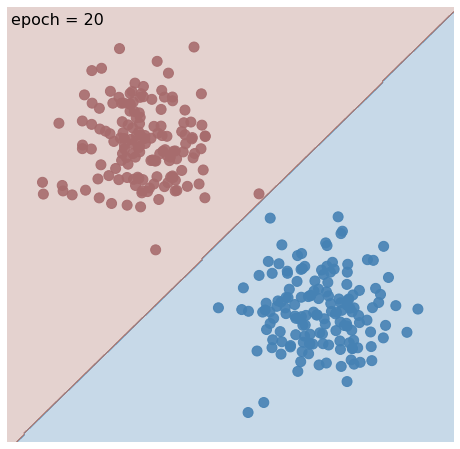

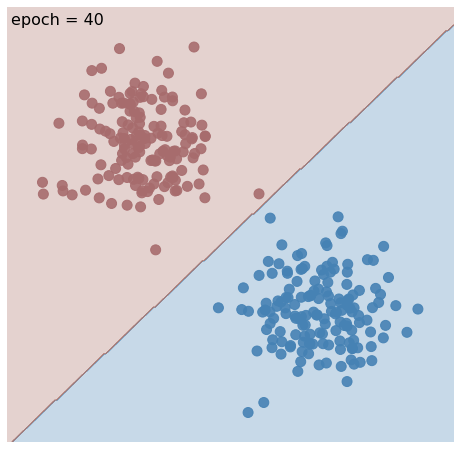

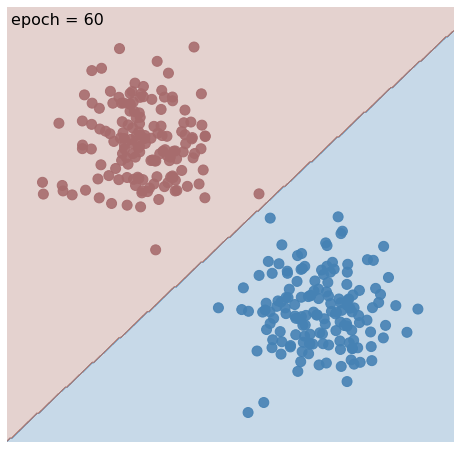

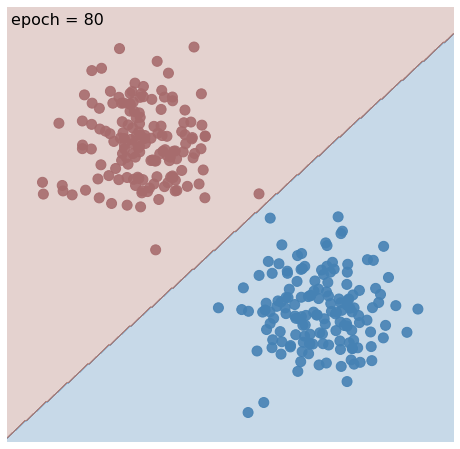

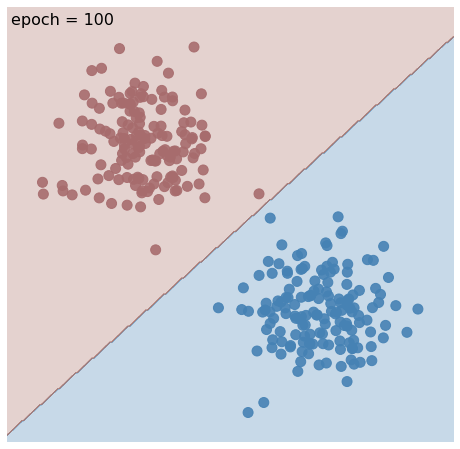

In [78]:
X_train, y_train = generate_data(300, "blobs")
X_valid, y_valid = generate_data(300, "blobs")

nn = Network([2, 3, 2])
nn.train(X_train, y_train, eta=0.25, num_epochs=100, isPrint=True, isVis=True)

**Part B**: OK!  If you think you've worked out the bugs, let's start looking at the results.  We'll build a simple neural network, train it on a training set, and watch the decision boundary of our classifier evolve to fit the data.  We can do this by running similar code as above, but with the `isVis` flag set to `True`. Note that producing the plots takes considerable computational work, so things will go a bit slower now.

Start with the blobs data set, and then move on to more complicated data sets like `moons`, `circles`, and finally the `checkerboard`. Note that for these more complicated geometries, it'll probably be necessary to chain the number of neurons in your hidden layer, or even add more hidden layers!   


epoch  10/100:   train loss:    0.116
epoch  20/100:   train loss:    0.151
epoch  30/100:   train loss:    0.059
epoch  40/100:   train loss:    0.046
epoch  50/100:   train loss:    0.031
epoch  60/100:   train loss:    0.023
epoch  70/100:   train loss:    0.028
epoch  80/100:   train loss:    0.011
epoch  90/100:   train loss:    0.009
epoch 100/100:   train loss:    0.008


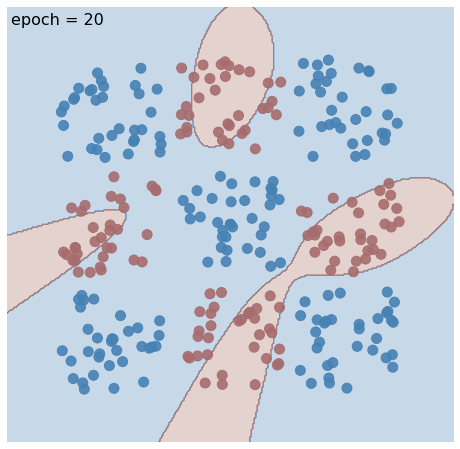

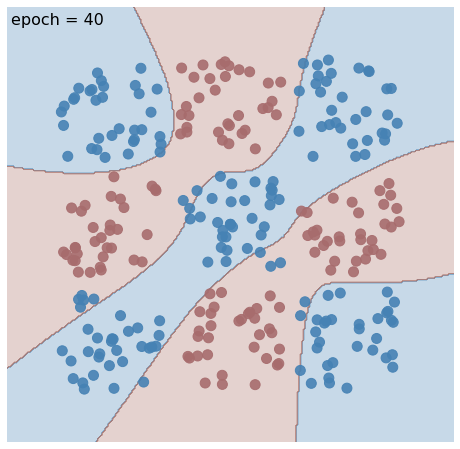

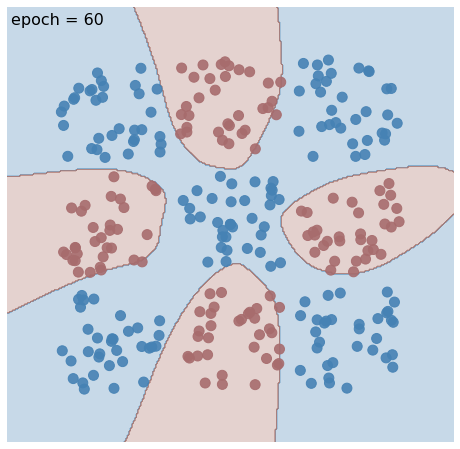

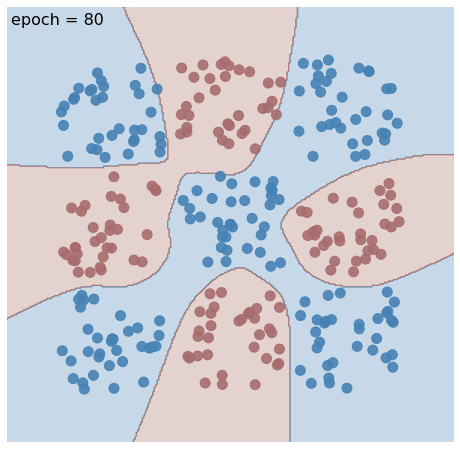

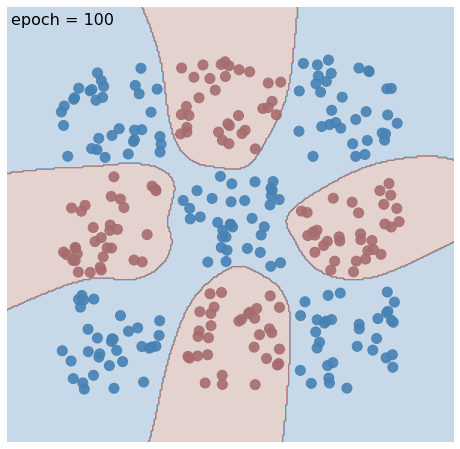

In [79]:
X_train, y_train = generate_data(300, "checkerboard")
X_valid, y_valid = generate_data(300, "checkerboard")

nn = Network([2,100,100,2])
nn.train(X_train, y_train, eta=0.25, num_epochs=100, isPrint=True, isVis=True)

epoch  10/100:   train loss:    0.017
epoch  20/100:   train loss:    0.004
epoch  30/100:   train loss:    0.002
epoch  40/100:   train loss:    0.001
epoch  50/100:   train loss:    0.001
epoch  60/100:   train loss:    0.001
epoch  70/100:   train loss:    0.001
epoch  80/100:   train loss:    0.000
epoch  90/100:   train loss:    0.000
epoch 100/100:   train loss:    0.000


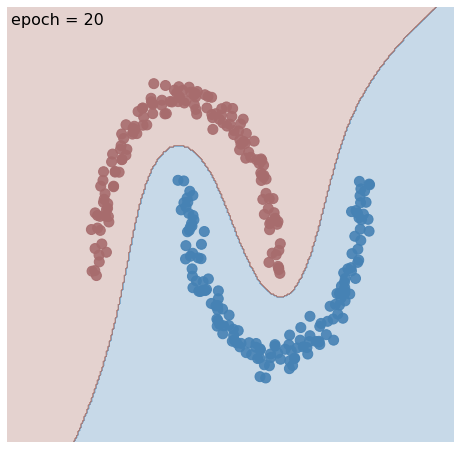

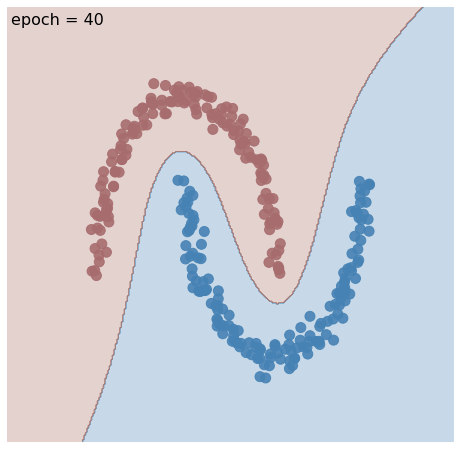

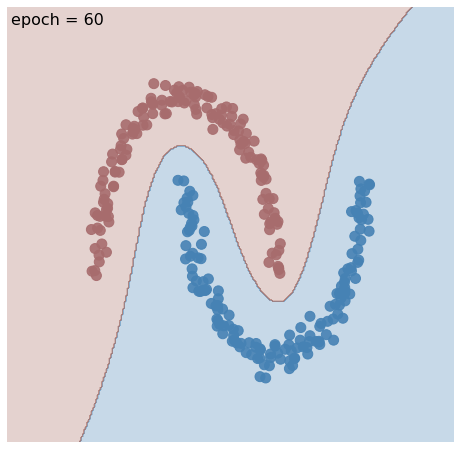

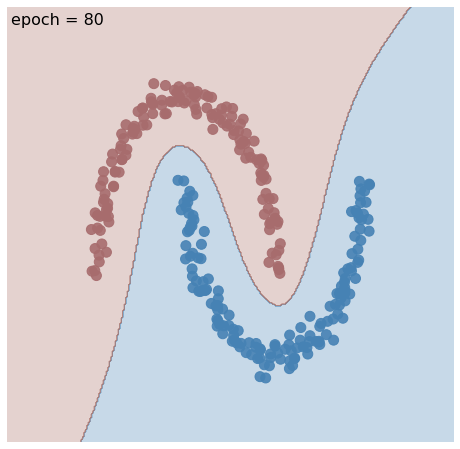

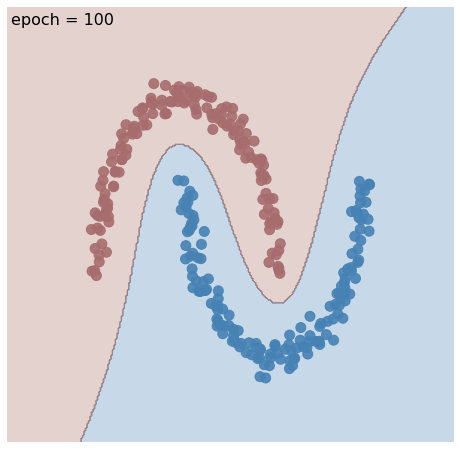

In [81]:
X_train, y_train = generate_data(300, "moons")
X_valid, y_valid = generate_data(300, "moons")

nn = Network([2,100,100,2])
nn.train(X_train, y_train, eta=0.25, num_epochs=100, isPrint=True, isVis=True)

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

### Helper Functions
***

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
%matplotlib inline

def generate_data(N, config="checkerboard"):
    X = np.zeros((N,2))
    y = np.zeros((N,2)).astype(int)
    
    if config=="checkerboard":
        nps, sqlen = N//9, 2/3
        ctr = 0
        for ii in range(3):
            for jj in range(3):
                X[ctr * nps : (ctr + 1) * nps, :] = np.column_stack(
                    (np.random.uniform(ii * sqlen +.05-1, (ii+1) * sqlen - .05 -1, size=nps),
                     np.random.uniform(jj * sqlen +.05-1, (jj+1) * sqlen - .05 -1, size=nps))) 
                y[ctr*nps:(ctr+1)*nps,(3*ii+jj)%2] = 1 
                ctr += 1
                
    if config=="blobs":            
        X, yflat = datasets.make_blobs(n_samples=N, centers=[[-.5,.5],[.5,-.5]],
                                       cluster_std=[.20,.20],n_features=2)
        for kk, yk in enumerate(yflat):
            y[kk,:] = np.array([1,0]) if yk else np.array([0,1])
            
    
    if config=="circles":
        kk=0
        while kk < N / 2:
            sample = 2 * np.random.rand(2) - 1 
            if np.linalg.norm(sample) <= .45:
                X[kk,:] = sample 
                y[kk,:] = np.array([1,0])
                kk += 1 
        while kk < N:
            sample = 2 * np.random.rand(2) - 1
            dist = np.linalg.norm(sample)
            if dist < 0.9 and dist > 0.55:
                X[kk,:] = sample 
                y[kk,:] = np.array([0,1])
                kk += 1
                
    if config=="moons":
        X, yflat = datasets.make_moons(n_samples=N, noise=.05)
        X[:,0] = .5 * (X[:,0] - .5)
        X[:,1] = X[:,1] - .25
        for kk, yk in enumerate(yflat):
            y[kk, :] = np.array([1,0]) if yk else np.array([0,1])
            
    return X, y

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

In [ ]:
a = np.array([1, 2])

In [ ]:
a.shape

In [ ]:
b = a.reshape(-1, 1)

In [ ]:
b.shape

In [ ]:
b, a

In [ ]:
a - b

In [ ]:
b

In [ ]:
c = a

In [ ]:
c

In [ ]:
a[0] = 3

In [ ]:
c

In [ ]:
a